# <div align='center'> Estimation of Survival Curve<br>
 $S(t) = Pr(T>t)$ 

## Requiremnts <br>
- ISLP package ([Follow for installation](https://pypi.org/project/ISLP/))

In [97]:
# importinig libraries
from ISLP.models import ModelSpec as MS
from ISLP import load_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns; sns.set()

from lifelines import KaplanMeierFitter, CoxPHFitter 
from lifelines.statistics import logrank_test, multivariate_logrank_test
from ISLP import load_data

# Brain Cancer dataset
- Contains the survival times for patients with primary brain tumors undergoing treatment with stereotactic radiation methods
- Conventional status code: 1 = uncensored observation (death) and 0 = censored observation

In [98]:
BrainCancer = load_data('BrainCancer')
BrainCancer.head()
# BrainCancer.shape

,sex,diagnosis,loc,ki,gtv,stereo,status,time
0,Female,Meningioma,Infratentorial,90,6.11,SRS,0,57.64
1,Male,HG glioma,Supratentorial,90,19.35,SRT,1,8.98
2,Female,Meningioma,Infratentorial,70,7.95,SRS,0,26.46
3,Female,LG glioma,Supratentorial,80,7.61,SRT,1,47.80
4,Male,HG glioma,Supratentorial,90,5.06,SRT,1,6.30


- Predictors: 
    1. gtv: Gross tumor volume (cm^3)
    2. sex
    3. Diagnosis: Meningioma, LG glioma, HG glioma and others
    4. ki: Karnofsky index
    5. loc: Tumor location
    6. stereo: Stereotactic methods (SRS and SRT) <br>
- Here the time is '$y_{i}$' (time to the *i*the event(censoring/death))

In [99]:
BrainCancer['sex'].value_counts()

Female    45
Male      43
Name: sex, dtype: int64

In [100]:
BrainCancer['diagnosis'].value_counts()

Meningioma    42
HG glioma     22
Other         14
LG glioma      9
Name: diagnosis, dtype: int64

In [101]:
BrainCancer['status'].value_counts()

0    53
1    35
Name: status, dtype: int64

So, the status indicates that 35 patients died before the end of the study

Text(0.5, 1.0, 'Survival curve for Brain Cancer')

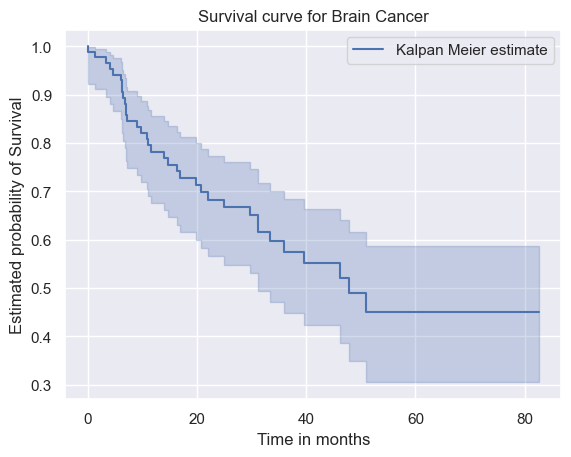

In [102]:
# Creating new object
km = KaplanMeierFitter()
# Fitting the data to the estimator and visualizing the survival curve
# Pointwise Confidence interval is set to 90% by default
km_brain = km.fit(BrainCancer['time'], BrainCancer['status'])
km_brain.plot(label = 'Kalpan Meier estimate')
plt.xlabel('Time in months')
plt.ylabel('Estimated probability of Survival')
plt.title('Survival curve for Brain Cancer')


# Kaplan-Meier survival curve - sex-stratified

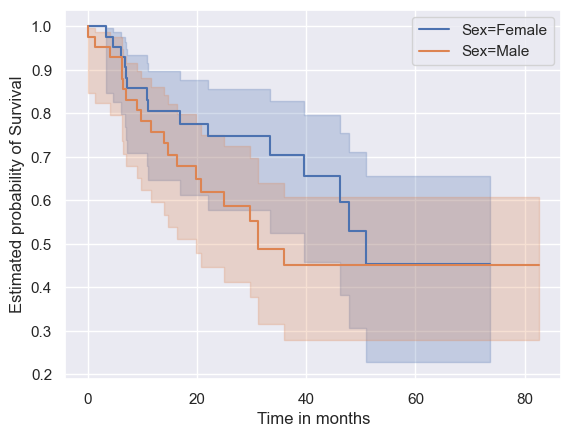

In [103]:
# Initializing a directory to store data frames for each sex category
by_sex = {}

for sex, df in BrainCancer.groupby('sex'):
    by_sex[sex] = df
    # Fitting the data to the estimator and visualizing the survival curve
    km_sex = km.fit(df['time'], df['status'])
    km_sex.plot(label = 'Sex=%s' % sex)
    plt.xlabel('Time in months')
    plt.ylabel('Estimated probability of Survival')

In [104]:
by_sex
# by_sex['Female']
# by_sex['Male']

{'Female':        sex   diagnosis             loc   ki    gtv stereo  status   time
 0   Female  Meningioma  Infratentorial   90   6.11    SRS       0  57.64
 2   Female  Meningioma  Infratentorial   70   7.95    SRS       0  26.46
 3   Female   LG glioma  Supratentorial   80   7.61    SRT       1  47.80
 5   Female  Meningioma  Supratentorial   80   4.82    SRS       0  52.75
 8   Female  Meningioma  Supratentorial   70  12.16    SRT       0  34.66
 11  Female  Meningioma  Infratentorial   90   6.54    SRS       0  34.26
 12  Female  Meningioma  Infratentorial   90   0.63    SRS       0  32.98
 14  Female  Meningioma  Supratentorial   60   9.18    SRT       0  41.44
 15  Female   HG glioma  Supratentorial   70  11.38    SRS       1   7.05
 16  Female       Other  Infratentorial   60  24.00    SRT       1   6.82
 19  Female  Meningioma  Supratentorial   90   2.50    SRT       0  30.16
 20  Female  Meningioma  Supratentorial   80   2.82    SRS       0  24.39
 22  Female       Other  Inf

# Log-Rank Test <br>
Comparing survival distributions between two groups



In [105]:
logrank_test(by_sex['Male']['time'], by_sex['Female']['time'], by_sex['Male']['status'], by_sex['Female']['status'])

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

The p-value = 0.23. So, there is no significant difference between the survival distributions of the two groups

# Cox Proportional Hazards Model <br>

In [106]:
coxph = CoxPHFitter
sex_df = BrainCancer[['time', 'status', 'sex']]
# Design matrix for the Cox model using model specification class (MS) with sex as the only predictor
model_df = MS(['time', 'status', 'sex'],intercept=False).fit_transform(sex_df)
cox_fit = coxph().fit(model_df , 'time','status')
# cox_fit.summary[['coef', 'se(coef)', 'p']]
cox_fit.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
sex[Male],0.407668,1.503309,0.342004,-0.262648,1.077984,0.769013,2.93875,0.0,1.191998,0.233262,2.099977


In [107]:
# Null model (with no features)
cox_fit.log_likelihood_ratio_test()

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 1
        test_name = log-likelihood ratio test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

- p-value from both the cox model(with one predictor, sex) and the null model suggests that adding the 'sex' predictor to the model did not lead to a significant increase in the model's ability to explain the observed survival outcomes

### Fitting a model that makes use of additional predictors

In [108]:
# cleaning the data
cleaned = BrainCancer.dropna()
# Design matrix
all_MS = MS(cleaned.columns , intercept=False)
all_df = all_MS.fit_transform(cleaned)
fit_all = coxph().fit(all_df ,
'time',
'status')
fit_all.summary
# fit_all.summary[['coef', 'se(coef)', 'p']]

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
sex[Male],0.183748,1.201712,0.360358,-0.522541,0.890036,0.593012,2.435218,0.0,0.509903,0.610119,0.712836
diagnosis[LG glioma],-1.239530,0.289520,0.579555,-2.375436,-0.103623,0.092974,0.901565,0.0,-2.138762,0.032455,4.945417
diagnosis[Meningioma],-2.154566,0.115954,0.450524,-3.037577,-1.271554,0.047951,0.280396,0.0,-4.782351,0.000002,19.138659
diagnosis[Other],-1.268870,0.281149,0.617672,-2.479486,-0.058255,0.083786,0.943409,0.0,-2.054278,0.039949,4.645705
loc[Supratentorial],0.441195,1.554563,0.703669,-0.937971,1.820361,0.391421,6.174084,0.0,0.626992,0.530665,0.914128
ki,-0.054955,0.946527,0.018314,-0.090850,-0.019061,0.913155,0.981120,0.0,-3.000768,0.002693,8.536573
gtv,0.034293,1.034887,0.022333,-0.009480,0.078065,0.990565,1.081192,0.0,1.535502,0.124661,3.003923
stereo[SRT],0.177778,1.194560,0.601578,-1.001293,1.356848,0.367404,3.883933,0.0,0.295519,0.767597,0.381578


### Survival curves for each diagnosis category
 - Partial dependence plots: Relationship between a predictor variable and the model's prediction while holding the values of other predictors constant(at their average values or commonly used values)
 -  Mode for categorical columns ('diagnosis') and the mean for numerical columns are calculated 

In [109]:
# Creating a list of all uique diagnosis
levels = cleaned['diagnosis'].unique()
def representative(series):
    if hasattr(series.dtype , 'categories'):
        return pd.Series.mode(series)
    else:
        return series.mean()
modal_data = cleaned.apply(representative , axis=0)

In [ ]:
modal_data.shape

In [110]:
modal_df = pd.DataFrame([modal_data.iloc[0] for _ in range(len(levels))])
modal_df['diagnosis'] = levels
# modal_df

In [111]:
modal_X = all_MS.transform(modal_df)
modal_X.index = levels
# modal_X

Text(0, 0.5, 'Estimated probability of Survival')

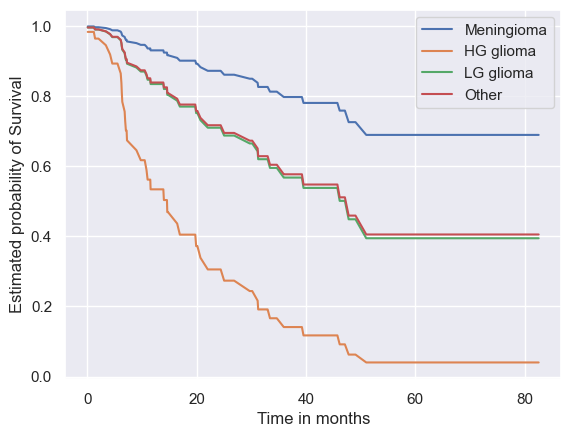

In [112]:
predicted_survival = fit_all.predict_survival_function(modal_X)
predicted_survival.plot()
plt.xlabel('Time in months')
plt.ylabel('Estimated probability of Survival')

# predicted_survival

# Follow the link for the [Tutorial](https://drive.google.com/file/d/14QWqblU0LXq3ZM1_-VPBqFyFvso_UqHG/view?usp=drive_link) video